# Film Junky Union - Machine Learning for Texts

### Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

**Objective**
The objective of this project is to train a machine learning model that can predict the sentiment of the text within movie reviews contained in the dataset to be used in future sentiment analysis for navigation by users of the Film Junky Union community.

**Dataset**
The data used in this project is taken from IMDB reviews with a column within the Dataframe indicating whether they skew positive or negative. This will allow our model to train and test efficiently without a lot of taxing encoding necessary. 

**Scope**:
    Data collection, preprocessing, visualization/EDA, feature labeling, training and testing of models, final analysis and conclusions. 
    
**Technical Details**
Logistic Regression, TF-IDF, LightBGM, Metric evaluation(F1, Accuracy, AUC-ROC, APS) will be used to train, test and optimize the models. 

**DISCLAIMER - BERT** was not used in the project due to computational limits. 

## Initialization

In [57]:
import math

import numpy as np
import pandas as pd
import spacy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc 

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

## Load Data

In [60]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## EDA

In [61]:
# Taking a first look at the DataFrame
display(df_reviews.sample(5))

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
20448,tt0102303,movie,Life Stinks,Life Stinks,1991,\N,92,0,Comedy,6.0,9240,"Another chapter in the ongoing question, whate...",3,neg,0,train,3108
22263,tt0106064,tvSeries,Mighty Morphin Power Rangers,Mighty Morphin Power Rangers,1993,1996,30,0,"Action,Adventure,Family",6.4,19694,"Come on, what is the deal with this show, Powe...",1,neg,0,train,9795
31834,tt0367085,movie,Soul Plane,Soul Plane,2004,\N,86,0,Comedy,4.5,21293,Frankly I did not think there was anything hum...,1,neg,0,test,7907
26835,tt0187844,tvEpisode,Premiere,Premiere,1999,\N,90,0,"Action,Adventure,Drama",8.0,3393,I heard about this series in 2001 which a frie...,10,pos,1,test,5578
9833,tt0321997,movie,Detention,Detention,2003,\N,98,0,"Action,Drama,Thriller",4.1,2147,I should preface this by stating that I am a D...,1,neg,0,train,3344


In [62]:
# Checking for duplicate rows
df_reviews.duplicated().sum()

0

In [63]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

The DataFrame is well ordered, free of clutter and columns are in the proper format. There are no duplicated rows, and plenty of data to train models on. The Dataframe also has a convenient column labeling training/test rows so we don't have to split it later on. 

### Data Visualization

We will now visualize the number of reviews over the years spanning the dataset. 

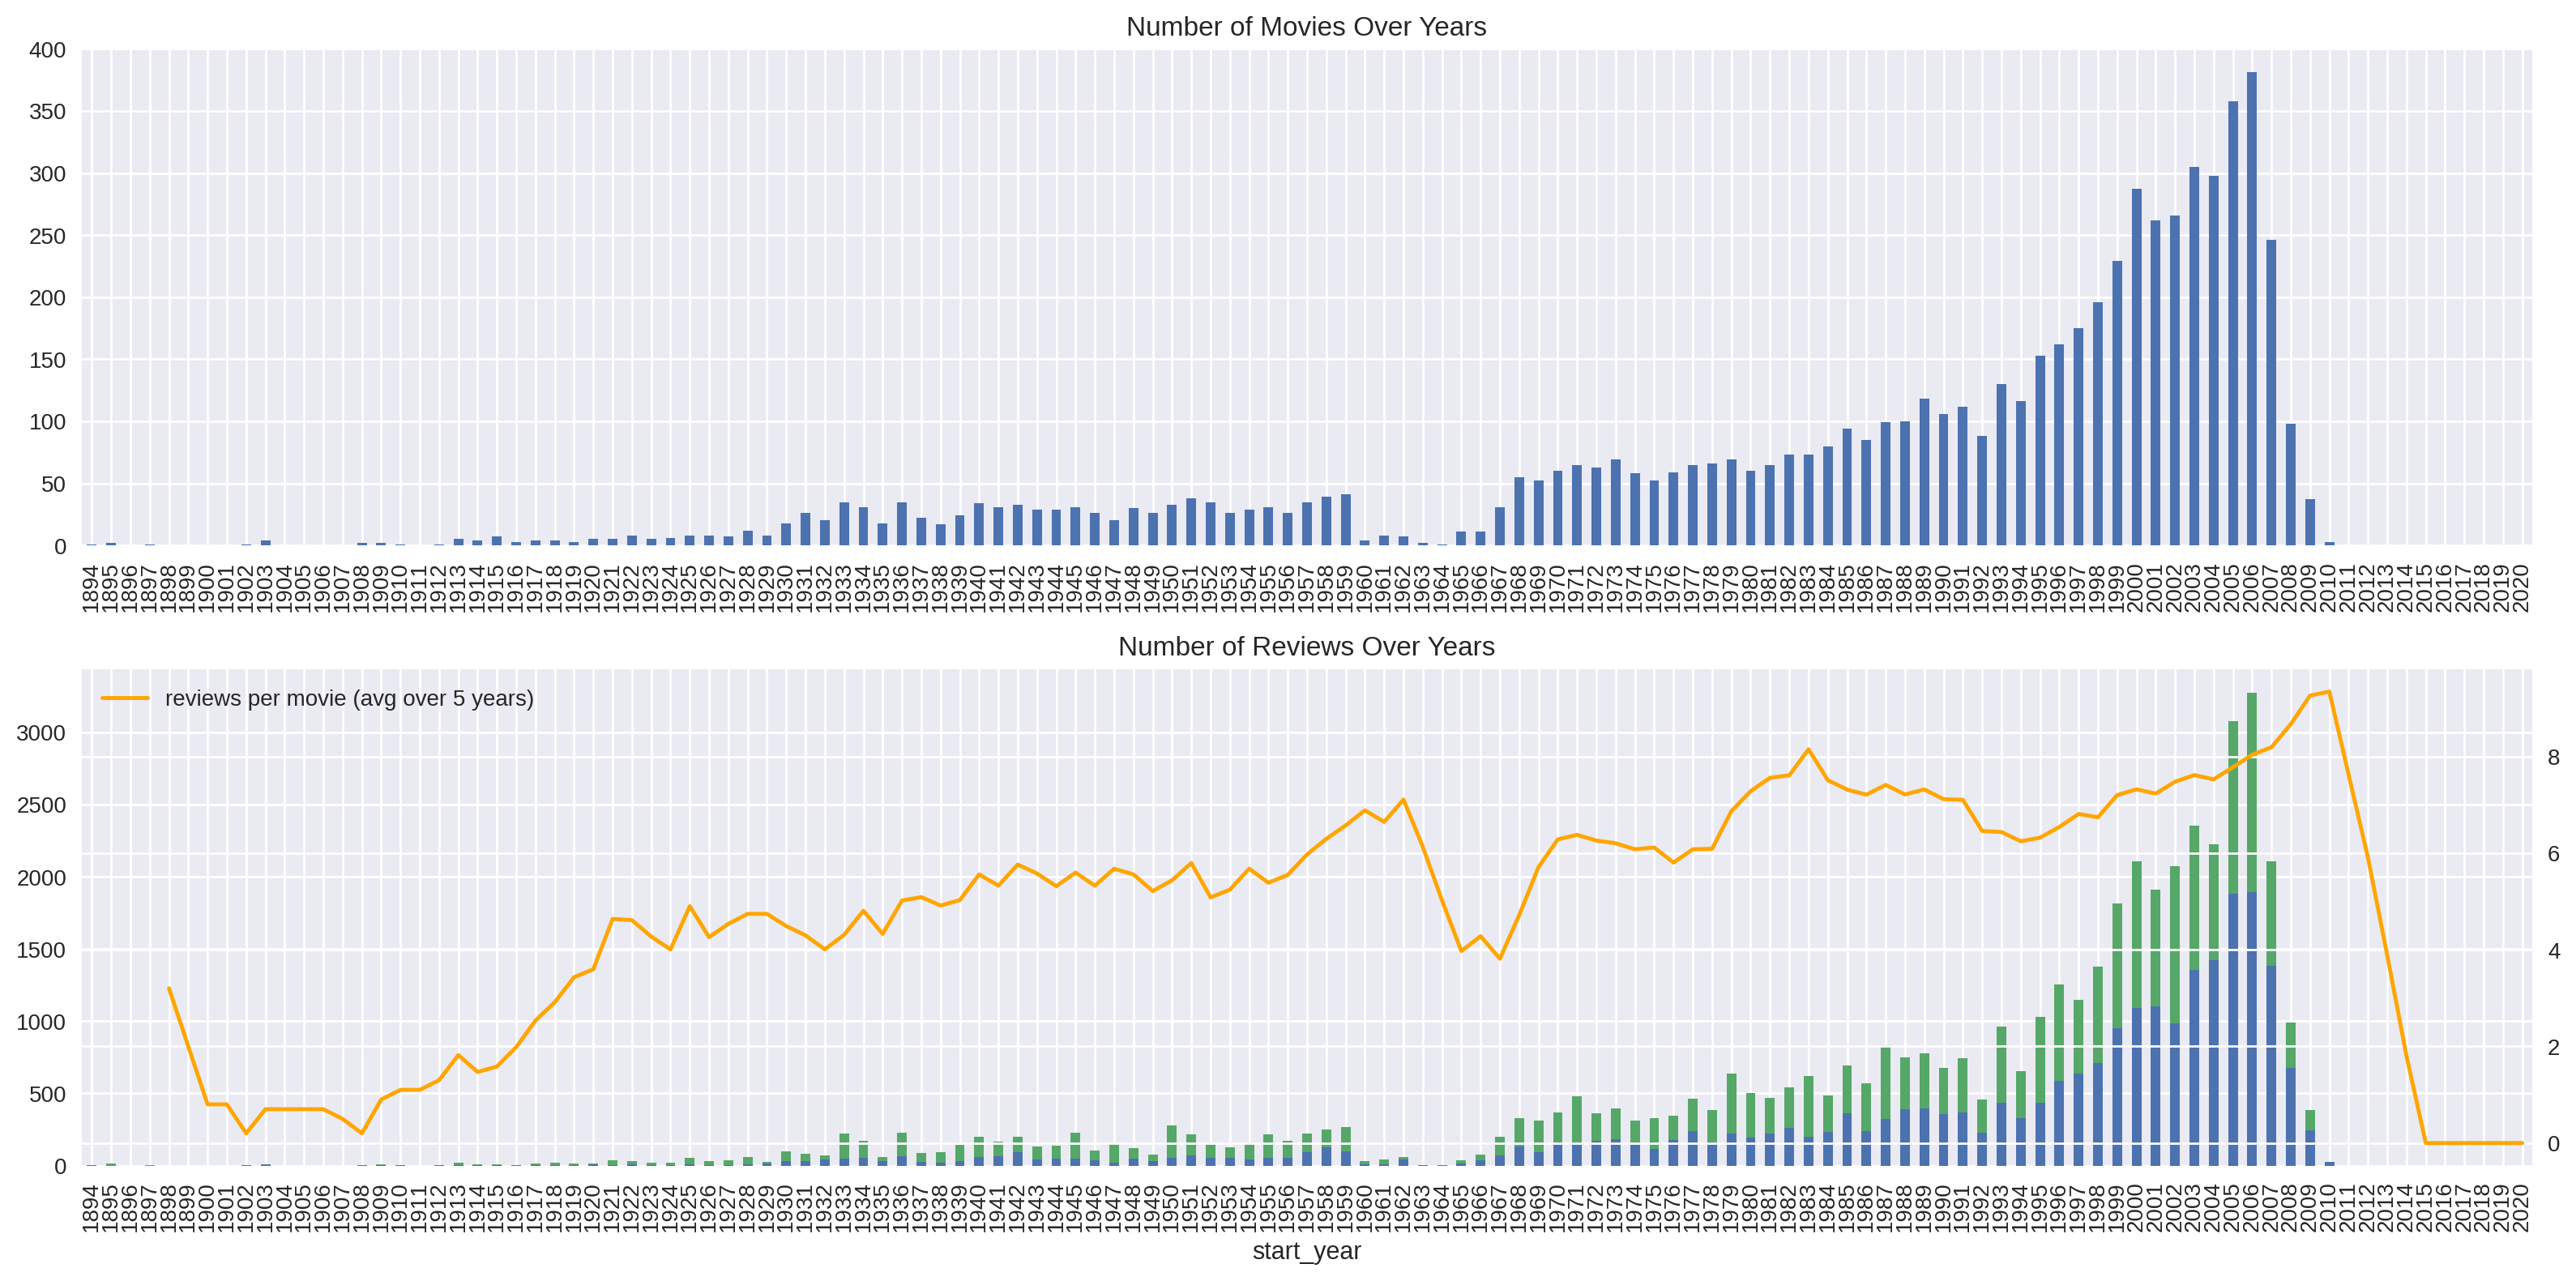

In [64]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

The bar chart above is useful in visualizing the number of movies present in the dataset at each yearly interval. There is a steady trend of movies from the 1930s through about 1960 when it suddenly drops in frequency for a few years. Beginning again in the late 1960s, the number of movies is somewhat stable until it increases exponentially before the next major dropoff around 2006-2007. 

The KDE analysis of the reviews chart shows that the reviews per movie is somewhat more consistent than the density of the overall movie frequency, as it is averaged over 5 years. This smoother distribution of reviews shows the overall trend in the reviews frequency over the years studied. It helps to see the negative vs positive reviews in the stacked bar format, allowing us to quickly reference how well the distribution of target elements is represented in the dataset. 

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

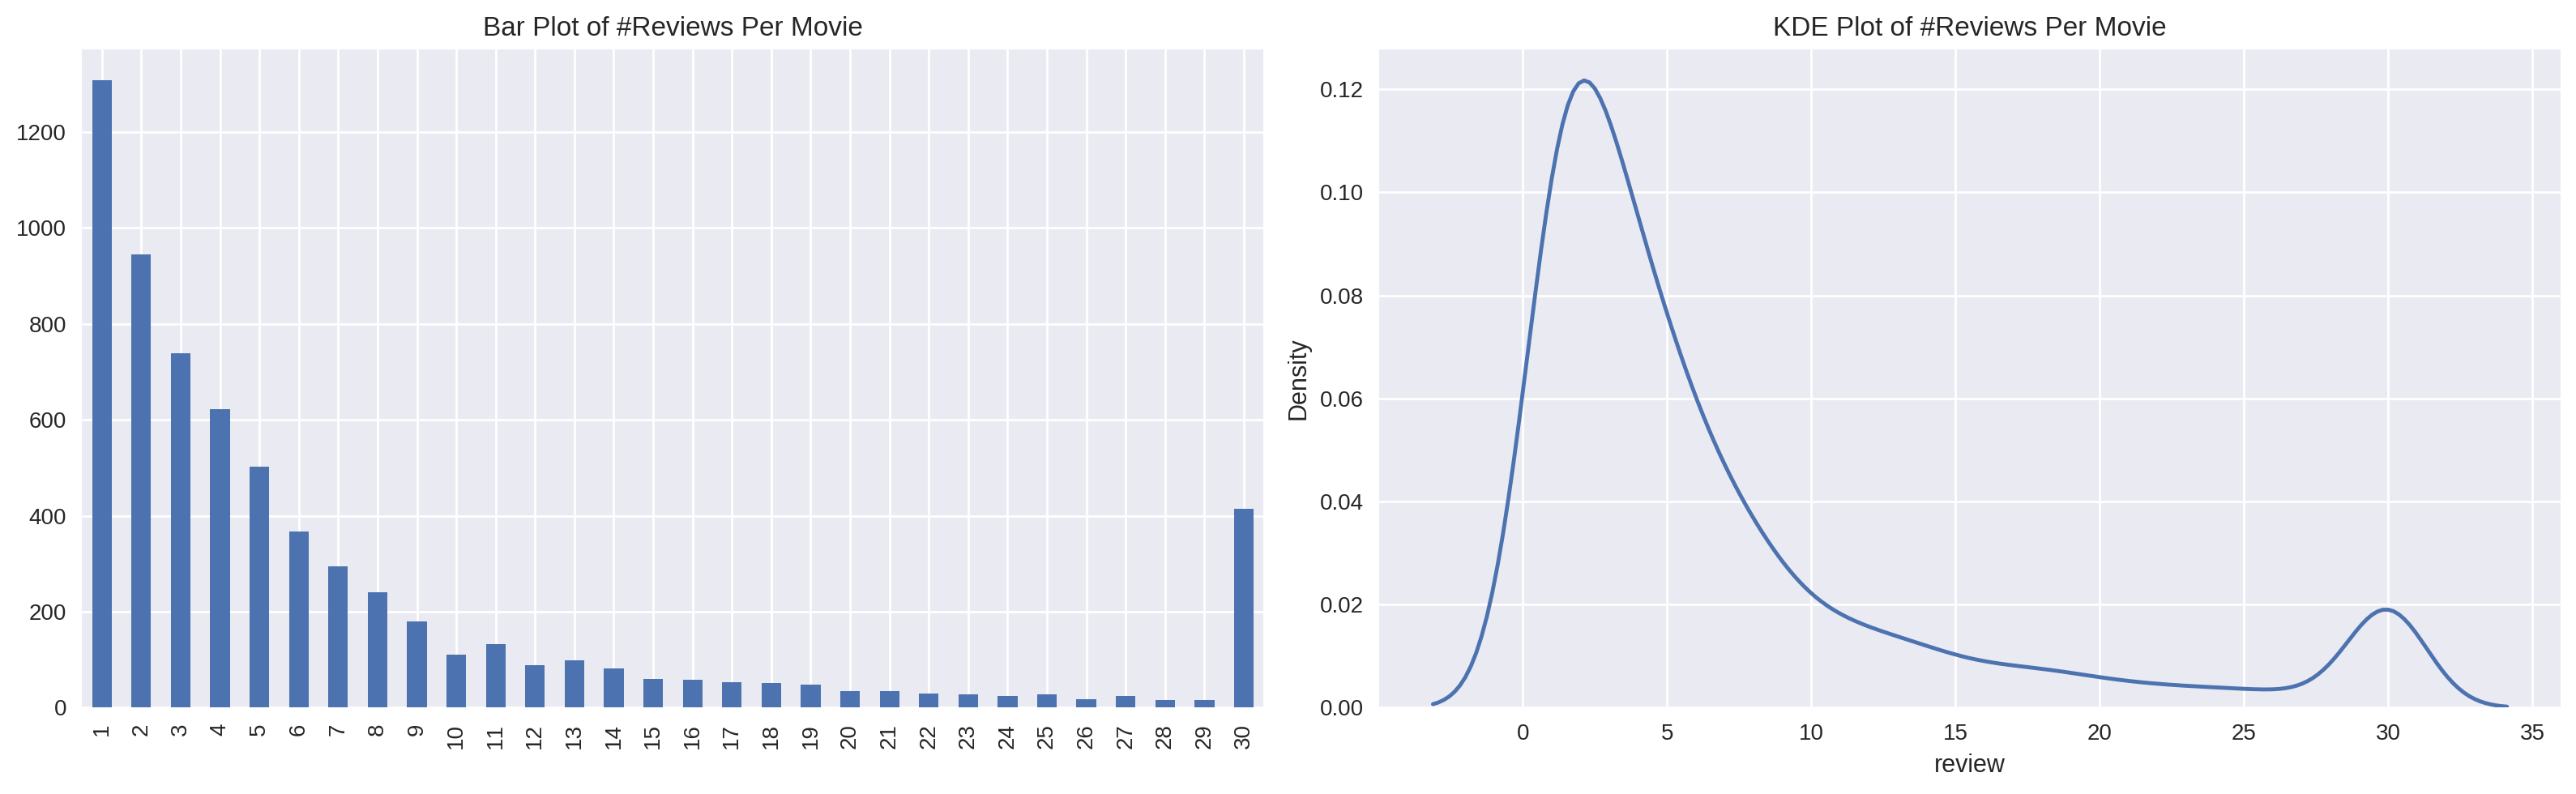

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

The vast majority of movies are receiving less than 5 reviews. There is a small outlier where more popular movies are getting 30 or more reviews. 

In [66]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

The distribution of negative vs positive reviews is well balanced, making for a much better training set on the ML models. 

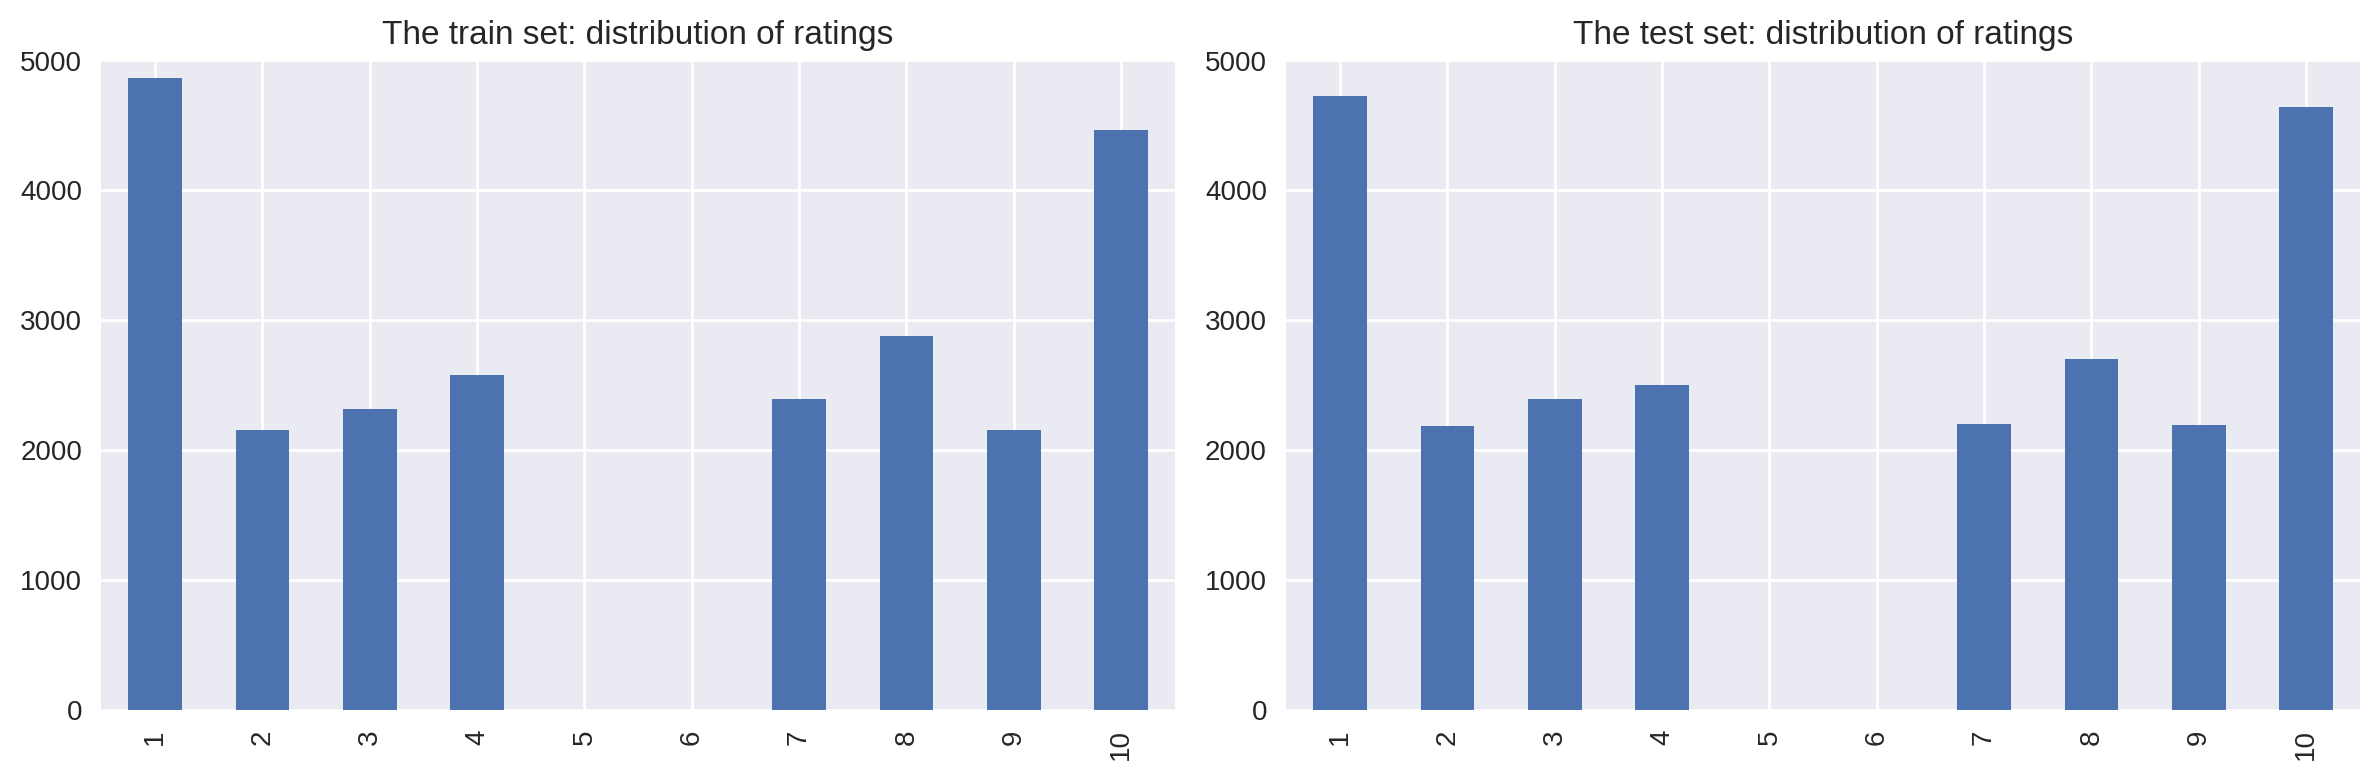

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

The distribution is very well balanced between the train and test sets, suggesting that class weights will not be an issue in the development of our models. 

Distribution of negative and positive reviews over the years for two parts of the dataset

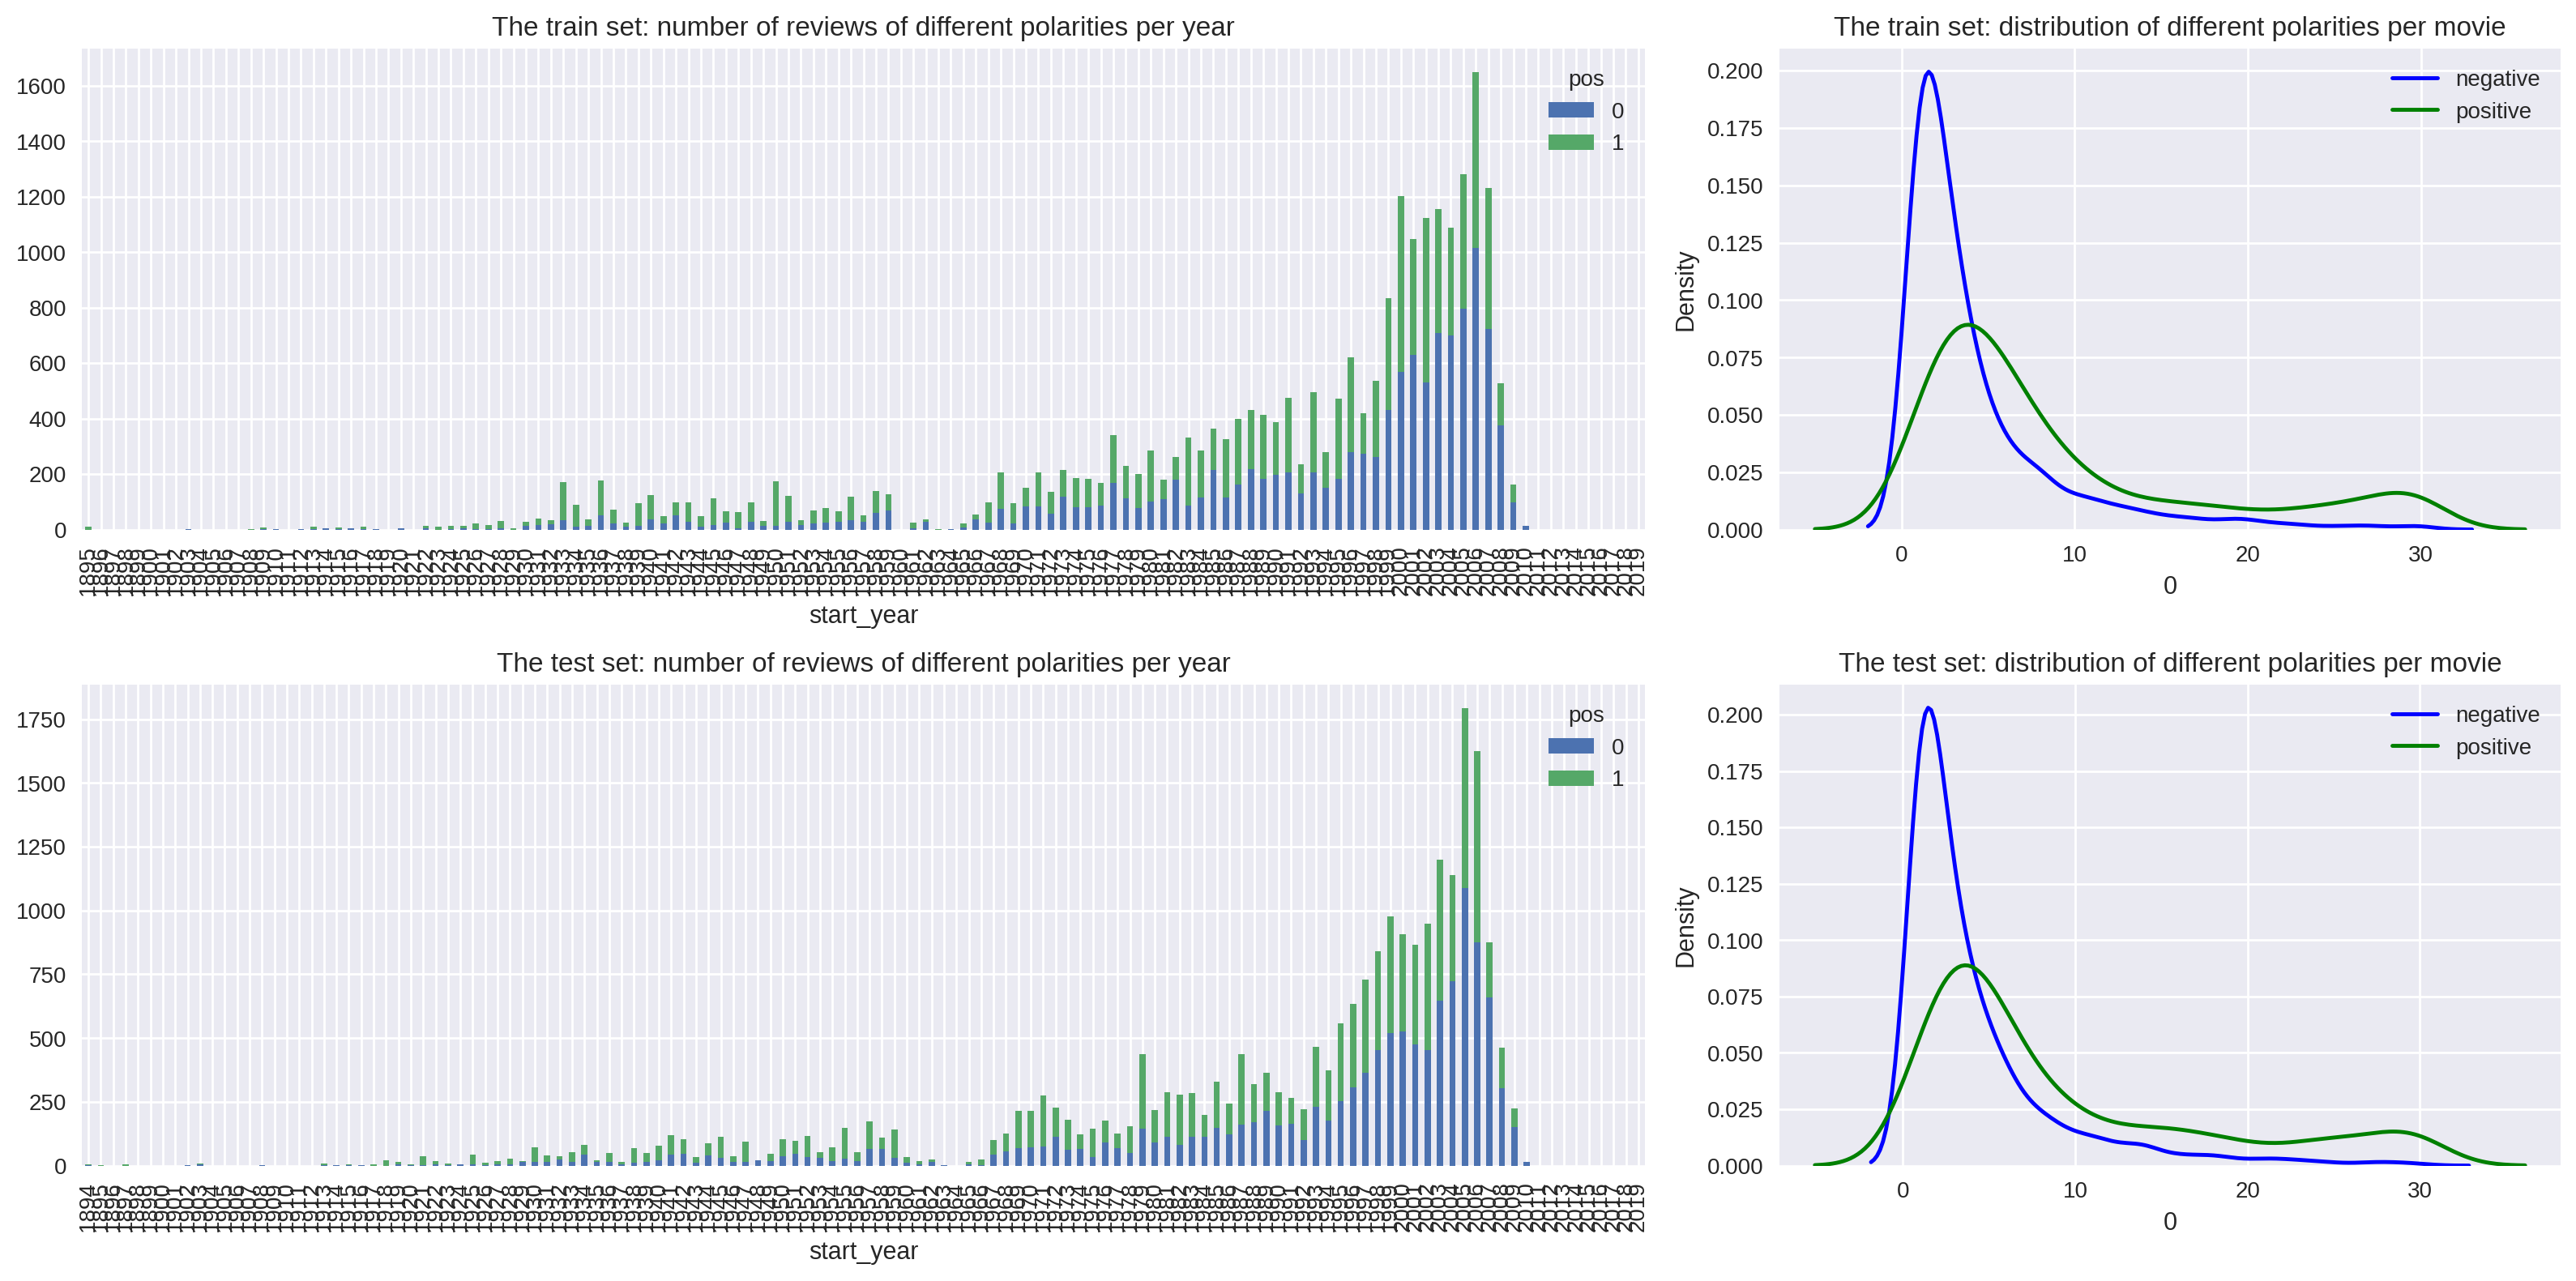

In [68]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

The distribution of the review polarity is well balanced between the train and test sets. The key takeaway from the charts on the right side of the above visual is the tendency for negative reviews to have a higher density earlier on in the dataset timeline, while positive reviews skew toward the right. This suggests that sentiment seems to improve as movies became more modern. Perhaps older movies received worse reviews while critics preferred movies that were produced closer in time to their experiences and sentiment. 

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [69]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for distinction, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[distinction] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[distinction]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[distinction]['APS'] = aps
        
        if distinction == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{distinction}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{distinction}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{distinction}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[distinction]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[distinction]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [70]:
df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [71]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

X_train = df_reviews_train['review_norm']
y_train = df_reviews_train['pos']

X_test = df_reviews_test['review_norm']
y_test = df_reviews_test['pos']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(23796,)
(23796,)
(23535,)
(23535,)


## Working with models

### Model 0 - Constant

In [72]:
# Using DummyClassifier for a baseline model
model = DummyClassifier(strategy="most_frequent")
model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


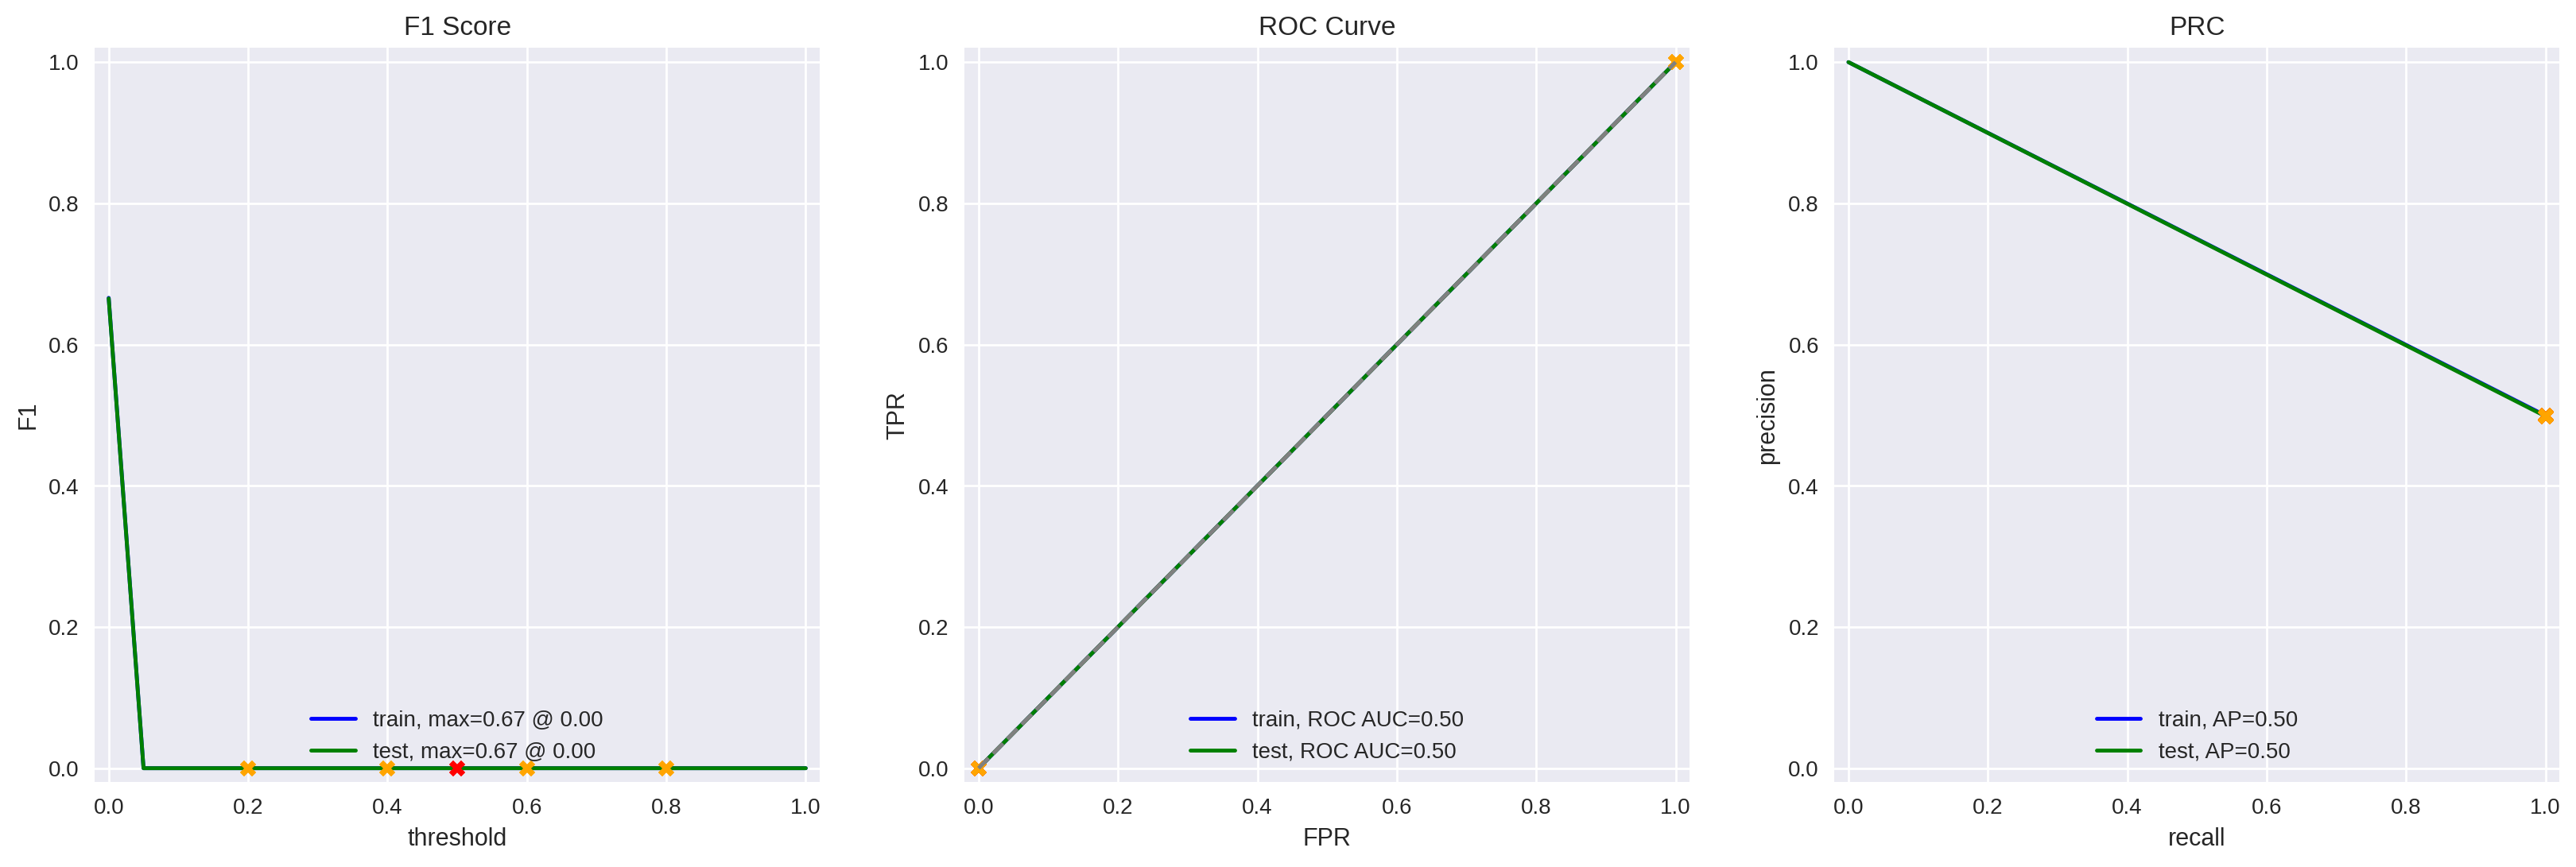

In [73]:
evaluate_model(model, X_train, y_train, X_test, y_test)

The baseline model's metrics show that NLP is much more complex and nuanced that other machine learning data tasks. There is much to improve on from the f1 score of 0.0.

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [74]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(str(text).lower())
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    lemmatized = ' '.join(lemmas)
    return lemmatized

In [75]:
X_train_lemmatized = X_train.progress_apply(lemmatize_text)
X_test_lemmatized = X_test.progress_apply(lemmatize_text)

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

In [76]:
nltk_stopwords = set(stopwords.words('english'))
count_tfidf = TfidfVectorizer(stop_words=nltk_stopwords)

train_tfidf = count_tfidf.fit_transform(X_train_lemmatized)
test_tfidf = count_tfidf.transform(X_test_lemmatized)

In [77]:
# Using LogisticRegression
model_1 = LogisticRegression(random_state=42)
model_1.fit(train_tfidf, y_train)

LogisticRegression(random_state=42)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


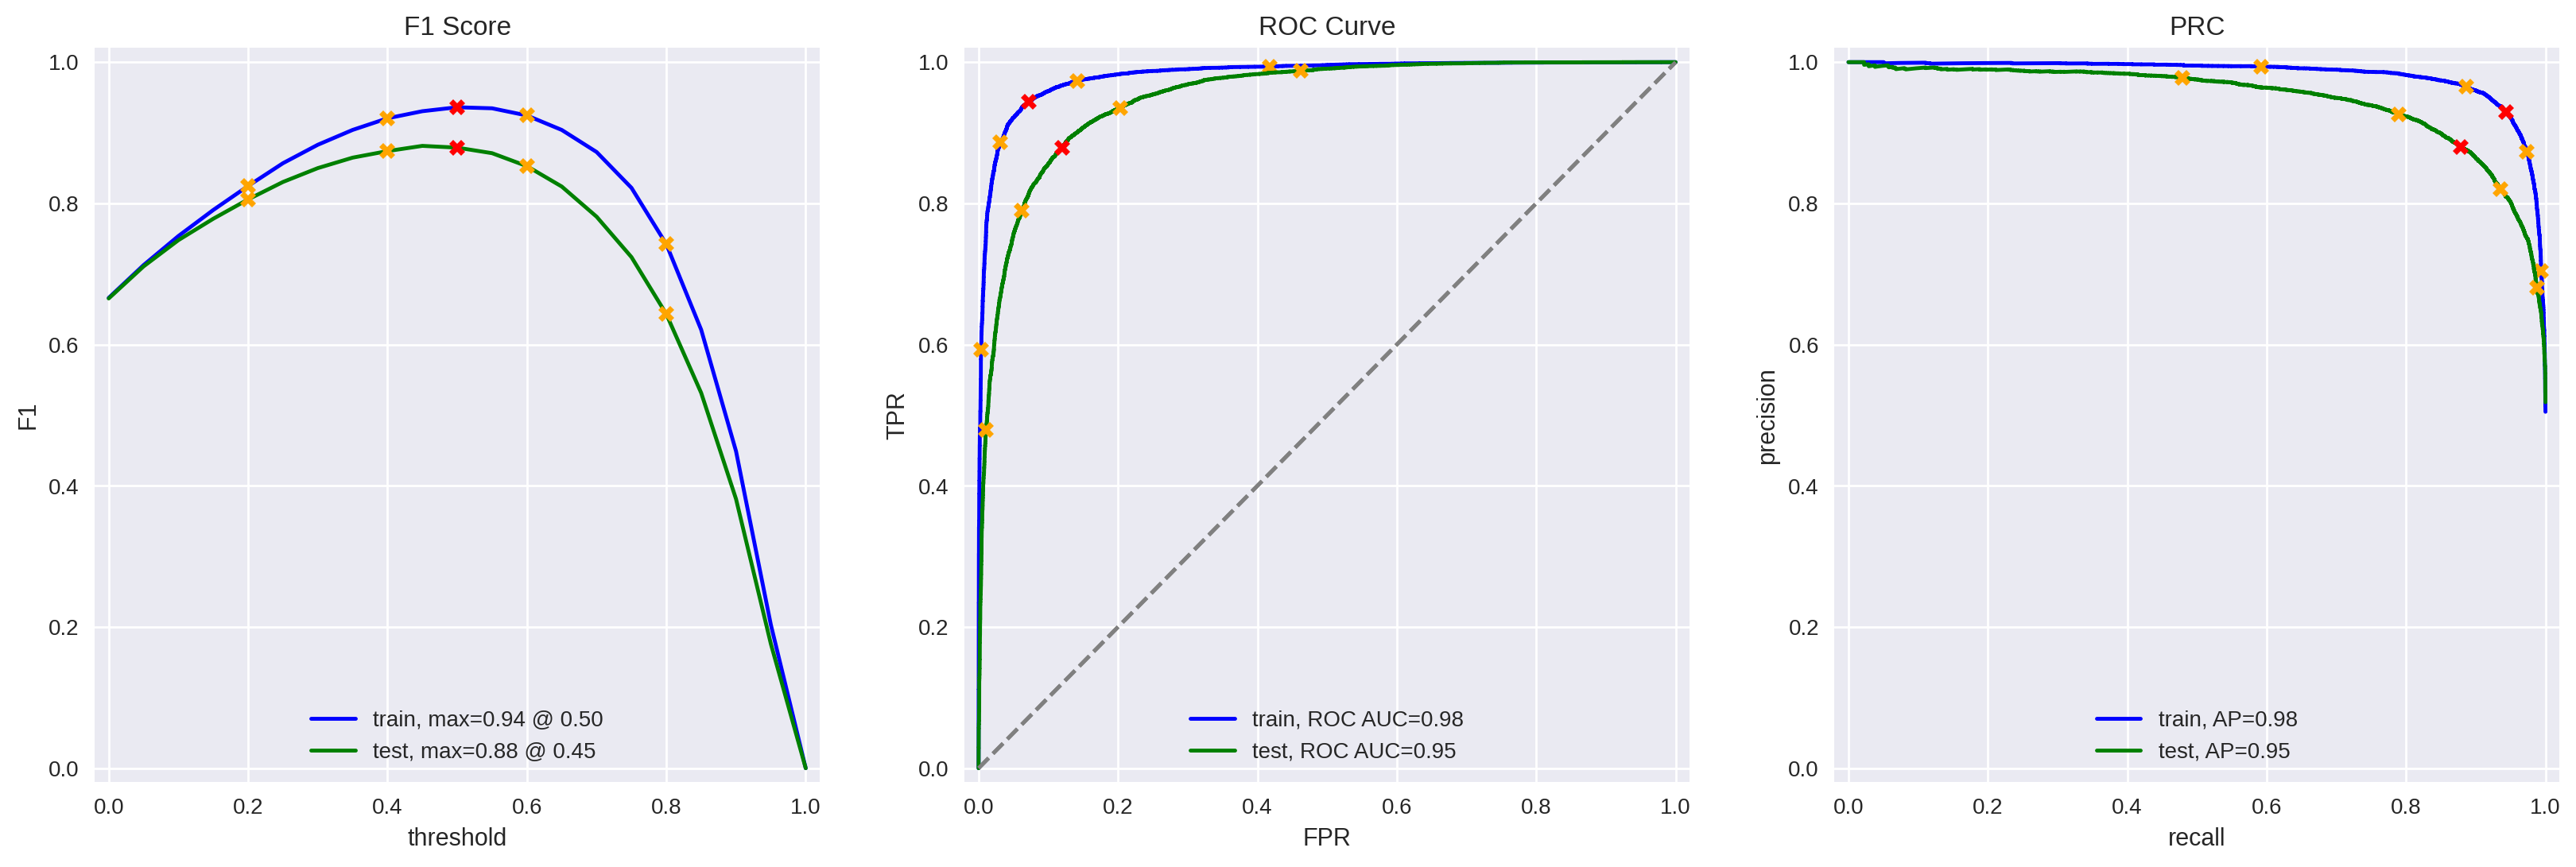

In [22]:
evaluate_model(model_1, train_tfidf, train_target, test_tfidf, test_target)

This is application of NLTK, TF-IDF and LR, we were able to achieve the required f1 score on the test set at 0.88, slightly above the minimum 0.85. 

### Model 3 - spaCy, TF-IDF and LR

In [23]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [24]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [25]:
X_train_spacy = X_train.progress_apply(text_preprocessing_3)

  0%|          | 0/23796 [00:00<?, ?it/s]

In [26]:
X_test_spacy = X_test.progress_apply(text_preprocessing_3)

  0%|          | 0/23535 [00:00<?, ?it/s]

In [27]:
train_tfidf_3 = count_tfidf.fit_transform(X_train_spacy)
test_tfidf_3 = count_tfidf.transform(X_test_spacy)

In [28]:
model_1.fit(train_tfidf_3, y_train)

LogisticRegression(random_state=42)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


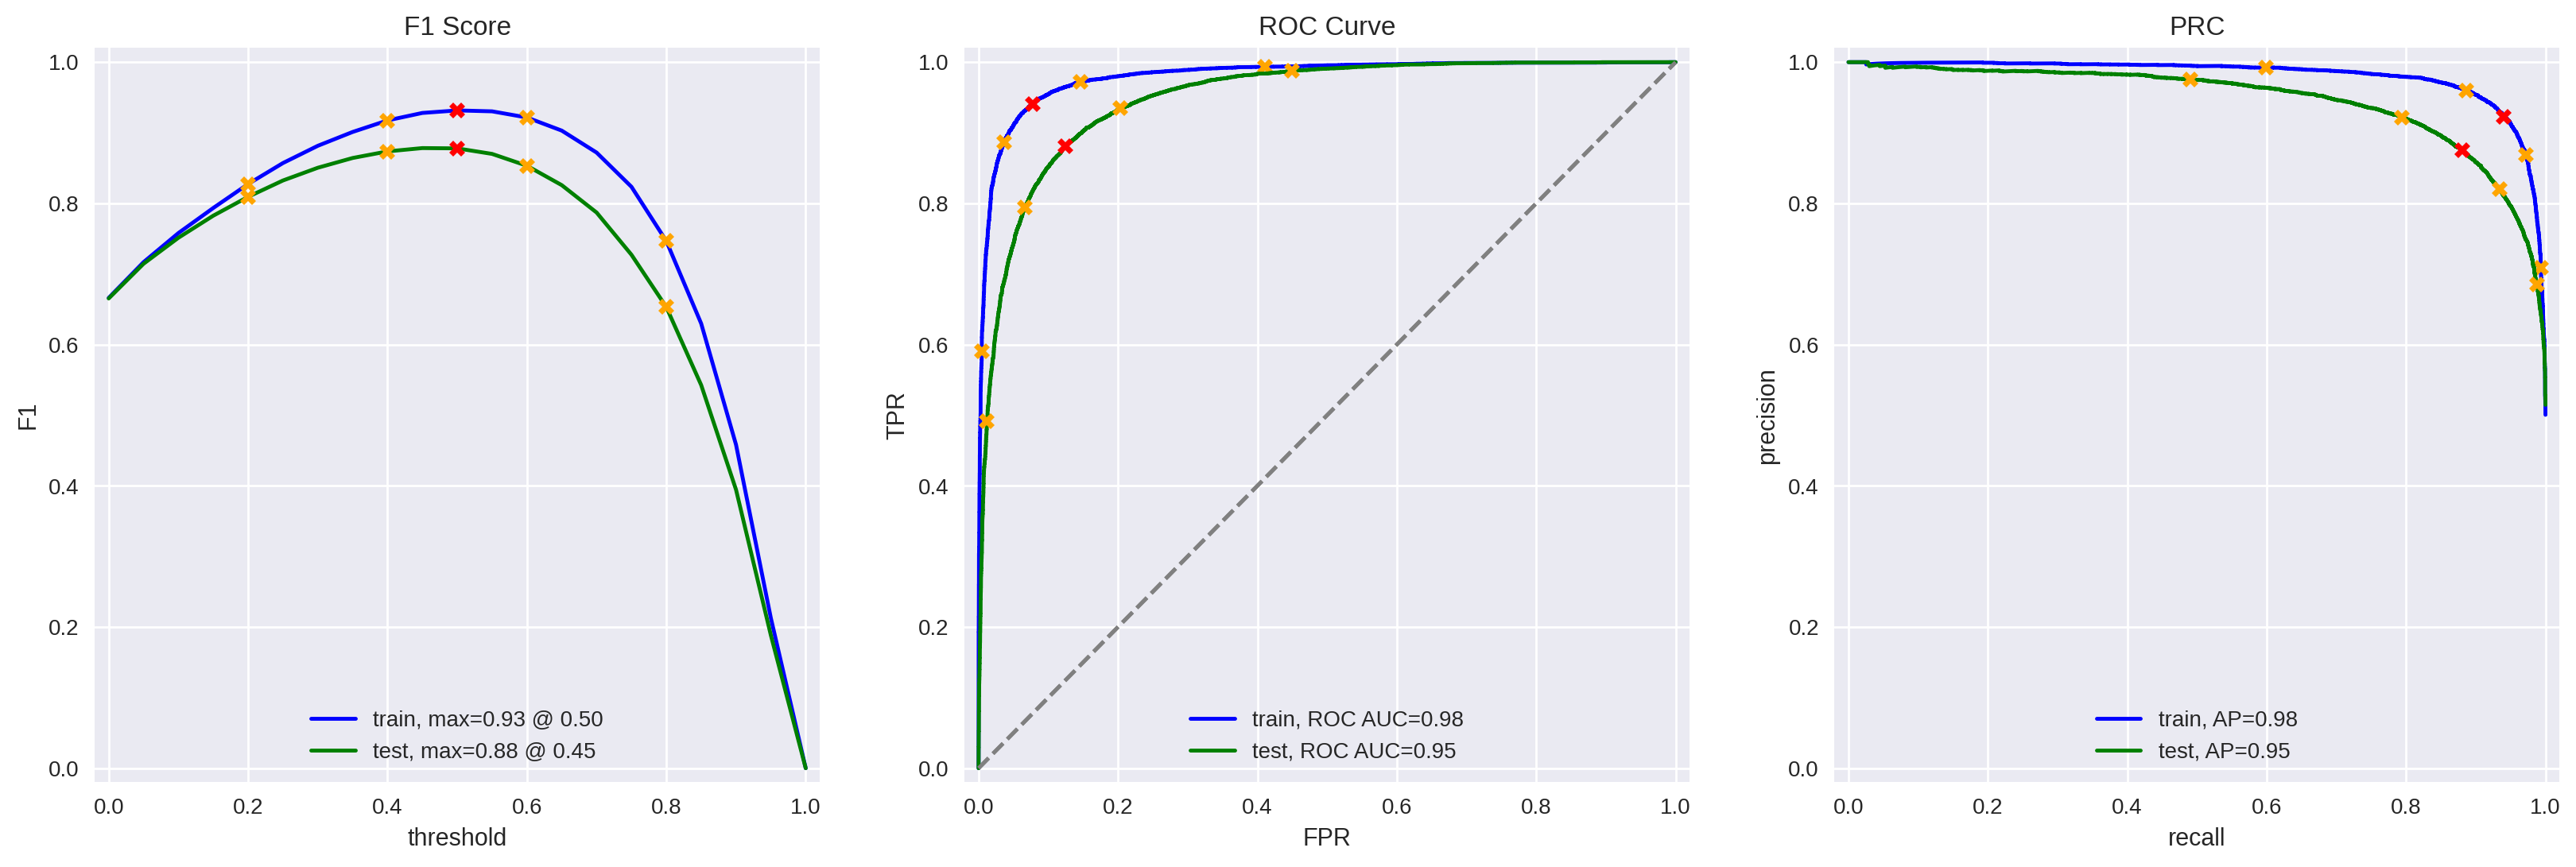

In [29]:
evaluate_model(model_1, train_tfidf_3 , y_train, test_tfidf_3, y_test)

Using spaCy achieved ever so slightly higher scores on the training set, while the test set had the same f1 score as the previous model. 

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [30]:
# Create and train the LGBMClassifier
model_4 = LGBMClassifier(random_state=42)
model_4.fit(train_tfidf_3, y_train)

LGBMClassifier(random_state=42)

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


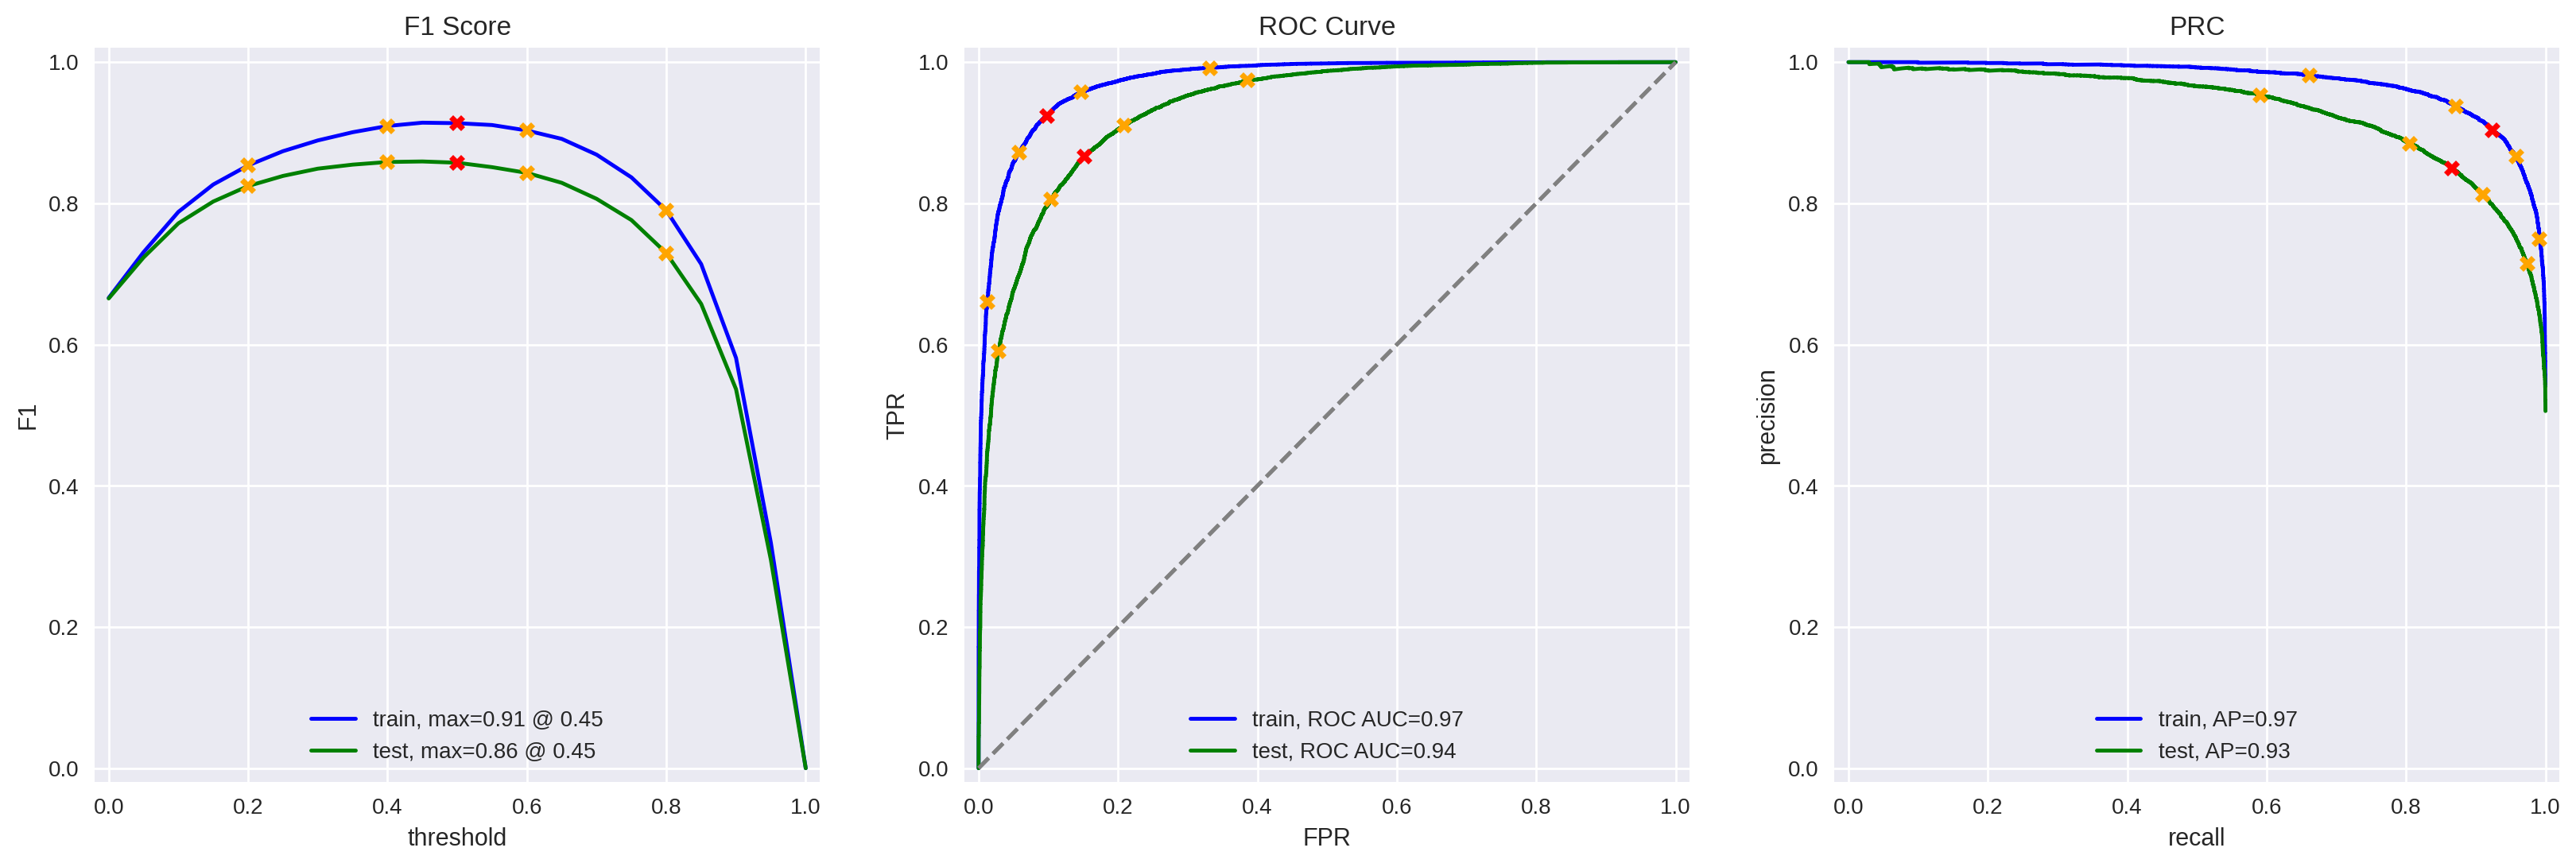

In [31]:
evaluate_model(model_4, train_tfidf_3, y_train, test_tfidf_3, y_test)

The addition of the LGBM classifier did not increase the F1 metric. This is likely due to a lack of hyperparameter tuning. Considering the resources required, I wouldn't recommend adding a cv search for tuning the LGBM model. 

###  Model 9 - BERT

I will not be using BERT due to the computational demands. All template cells relating to BERT have been removed. 

## My Reviews

In [78]:
reviews = [
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and fell asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a joke.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see watching it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even for a movie of this genre.',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode.',
]

my_reviews = pd.DataFrame(reviews, columns=['review'])

# Normalize the review text
my_reviews['review_norm'] = my_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')

# Manually label the sentiment of each review
labels = [
    0,  # Negative
    0,  # Negative
    1,  # Positive
    0,  # Negative
    1,  # Positive
    1,  # Positive
    0,  # Negative
    1   # Positive
]

# Add labels to the DataFrame
my_reviews['pos'] = labels

# Display the DataFrame with the labeled sentiment
print(my_reviews)

                                              review  \
0    I did not simply like it, not my kind of movie.   
1  Well, I was bored and fell asleep in the middl...   
2             I was really fascinated with the movie   
3  Even the actors looked really old and disinter...   
4  I didn't expect the reboot to be so good! Writ...   
5  The movie had its upsides and downsides, but I...   
6  What a rotten attempt at a comedy. Not a singl...   
7  Launching on Netflix was a brave move & I real...   

                                         review_norm  pos  
0    i did not simply like it  not my kind of movie     0  
1  well  i was bored and fell asleep in the middl...    0  
2             i was really fascinated with the movie    1  
3  even the actors looked really old and disinter...    0  
4  i didn t expect the reboot to be so good  writ...    1  
5  the movie had its upsides and downsides  but i...    1  
6  what a rotten attempt at a comedy  not a singl...    0  
7  launching on

### Model 1

In [79]:
# Applying lemmatization on the new reviews
my_reviews_lemmatized = my_reviews['review_norm'].apply(lemmatize_text)

# Transforming the lemmatized new reviews with the same vectorizer
my_reviews_tfidf = count_tfidf.transform(my_reviews_lemmatized)

# Predicting the probabilities with the trained model
my_reviews_pred_prob = model_1.predict_proba(my_reviews_tfidf)[:, 1]

# Printing the results
for i, review in enumerate(my_reviews_lemmatized.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}: {review}')

0.15: i did not simply like it not my kind of movie
0.15: well i wa bored and fell asleep in the middle of the movie
0.46: i wa really fascinated with the movie
0.05: even the actor looked really old and disinterested and they got paid to be in the movie what a joke
0.29: i didn t expect the reboot to be so good writer really cared about the source material
0.43: the movie had it upside and downside but i feel like overall it s a decent flick i could see watchin
0.05: what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even for a m
0.78: launching on netflix wa a brave move i really appreciate being able to binge on episode after episod


### Model 3

In [80]:
train_tfidf_3 = count_tfidf.fit_transform(X_train_spacy)
test_tfidf_3 = count_tfidf.transform(X_test_spacy)

model_1.fit(train_tfidf_3, y_train)

LogisticRegression(random_state=42)

In [81]:
my_reviews_pred_prob = model_1.predict_proba(count_tfidf.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it  not my kind of movie 
0.10:  well  i was bored and fell asleep in the middle of the movie 
0.48:  i was really fascinated with the movie
0.04:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a jo
0.26:  i didn t expect the reboot to be so good  writers really cared about the source material
0.45:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see wa
0.05:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even fo
0.86:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


### Model 4

In [82]:
tfidf_vectorizer_4 = count_tfidf
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]   

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}: {review}')

0.58: i did not simply like it  not my kind of movie 
0.39: well  i was bored and fell asleep in the middle of the movie 
0.58: i was really fascinated with the movie
0.29: even the actors looked really old and disinterested  and they got paid to be in the movie  what a jo
0.64: i didn t expect the reboot to be so good  writers really cared about the source material
0.71: the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see wa
0.25: what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even fo
0.79: launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


## Conclusions

#### My Reviews Analysis

It appears that the size of the data being trained on had a negative effect on the models' abilities to predict the sentiment of the reviews. The sentiment prediction was inconsistent in its ability to determine whether the reviews were positive, as was set in the 'pos' column.  

The LightBGM was somewhat better than the TF_IDF with LR, but it appears the vectorizer within model 3 was the most accurate at predicting the sentiment on this smaller dataset.  

I would expect some improvement with a dataset around 5-10 times larger than the one we attempted to use the same models on. The metrics on the main dataset were easily able to achieve f1 scores greater that 0.85. This shows that a properly trained model is very effective and predicting the sentiment using TF-IDF, spaCy, LGBMClassifier and LR. I was especially impressed when it was not even necessary to employ cross validation for hyperparameter tuning. 

#### Overall Conclusions

Due to the way these models are vectoring the text based on context and not meaning, like the way humans primarily understand language, it shows the limits of machine learning models and the complex nature of NLP. 

Although occasional errors occured, the selected models were able to perform quite well considering the limited size of the data, less than optimal paramter tuning and computational constraints. These models are an excellent way to determine which approach to take when processing text based data. 

The accuracy and F1 metrics shown by the combination of spaCy, TF-IDF and LR were paramount in demonstrating the nuances of each model, tuning methods and importance of preprocessing. 